In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
class CustomConv2D(Layer):
    def __init__(self, filters, kernel_size, padding='same', activation=None, **kwargs):
        super(CustomConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(
            kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(self.kernel_size[0], self.kernel_size[1],
                   input_shape[-1], self.filters),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.bias = self.add_weight(
            name="bias", shape=(self.filters,), initializer="zeros", trainable=True
        )

    def call(self, inputs):
        if self.padding == 'same':
            pad_height = self.kernel_size[0] // 2
            pad_width = self.kernel_size[1] // 2
            inputs = tf.pad(inputs, [[0, 0], [pad_height, pad_height], [
                            pad_width, pad_width], [0, 0]])
        conv_output = tf.nn.conv2d(inputs, self.kernel, strides=[
                                   1, 1, 1, 1], padding='VALID')
        conv_output = tf.nn.bias_add(conv_output, self.bias)
        if self.activation:
            conv_output = self.activation(conv_output)
        return conv_output

    def compute_output_shape(self, input_shape):
        if self.padding == 'same':
            output_height = input_shape[1]
            output_width = input_shape[2]
        else:
            output_height = input_shape[1] - self.kernel_size[0] + 1
            output_width = input_shape[2] - self.kernel_size[1] + 1
        return (input_shape[0], output_height, output_width, self.filters)

    def get_config(self):
        # Include all arguments passed to `__init__` here
        config = super(CustomConv2D, self).get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "padding": self.padding,
            "activation": tf.keras.activations.serialize(self.activation),
        })
        return config

In [ ]:
class CustomMaxPooling2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding='valid', **kwargs):
        super(CustomMaxPooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size if isinstance(
            pool_size, tuple) else (pool_size, pool_size)
        self.strides = strides if isinstance(
            strides, tuple) else (strides, strides)
        self.padding = padding

    def call(self, inputs):
        return tf.nn.max_pool2d(
            inputs,
            ksize=self.pool_size,
            strides=self.strides,
            padding=self.padding.upper()
        )

    def compute_output_shape(self, input_shape):
        if self.padding == 'same':
            output_height = input_shape[1]
            output_width = input_shape[2]
        else:
            output_height = (
                input_shape[1] - self.pool_size[0]) // self.strides[0] + 1
            output_width = (
                input_shape[2] - self.pool_size[1]) // self.strides[1] + 1
        return (input_shape[0], output_height, output_width, input_shape[3])

    def get_config(self):
        config = super(CustomMaxPooling2D, self).get_config()
        config.update({
            "pool_size": self.pool_size,
            "strides": self.strides,
            "padding": self.padding,
        })
        return config

In [155]:
class CustomDense(Layer):
    def __init__(self, units, activation=None, kernel_regularizer=None, **kwargs):
        super(CustomDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        # Validate the input shape
        if input_shape[-1] is None:
            raise ValueError(
                f"Input shape for CustomDense cannot have None. Got: {input_shape}")
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            regularizer=self.kernel_regularizer,
            trainable=True
        )
        self.bias = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        outputs = tf.matmul(inputs, self.kernel) + self.bias
        if self.activation:
            outputs = self.activation(outputs)
        return outputs


    def get_config(self):
        # Return a dictionary of the layer's configuration
        config = super(CustomDense, self).get_config()
        config.update({
            'units': self.units,
            'activation': self.activation,
            'kernel_regularizer': self.kernel_regularizer,
        })
        return config

In [ ]:
class CustomBatchNormalization(Layer):
    def __init__(self, momentum=0.99, epsilon=1e-3, axis=-1, **kwargs):
        """
        Custom implementation of Batch Normalization.
        Args:
            momentum: Momentum for the moving average updates.
            epsilon: Small constant to avoid division by zero.
            axis: Axis to normalize (e.g., -1 for channels-last).
            **kwargs: Additional arguments for the base layer.
        """
        super(CustomBatchNormalization, self).__init__(**kwargs)
        self.momentum = momentum
        self.epsilon = epsilon
        self.axis = axis

    def build(self, input_shape):
        """
        Initializes the layer's weights.
        """
        # Determine the shape of the normalization axis
        param_shape = (input_shape[self.axis],)

        # Trainable parameters
        self.gamma = self.add_weight(
            name="gamma",
            shape=param_shape,
            initializer="ones",
            trainable=True
        )
        self.beta = self.add_weight(
            name="beta",
            shape=param_shape,
            initializer="zeros",
            trainable=True
        )

        # Moving statistics
        self.moving_mean = self.add_weight(
            name="moving_mean",
            shape=param_shape,
            initializer="zeros",
            trainable=False
        )
        self.moving_variance = self.add_weight(
            name="moving_variance",
            shape=param_shape,
            initializer="ones",
            trainable=False
        )

    def call(self, inputs, training=False, mask=None):
        """
        Performs the normalization operation.
        Args:
            inputs: Input tensor.
            training: Whether the layer is in training mode.
            mask: Optional mask for inputs.
        """
        # Compute batch statistics
        if training:
            axes = [i for i in range(len(inputs.shape)) if i != self.axis]
            mean, variance = tf.nn.moments(inputs, axes=axes, keepdims=True)

            # Update moving statistics
            self.moving_mean.assign(
                self.moving_mean * self.momentum + mean * (1 - self.momentum)
            )
            self.moving_variance.assign(
                self.moving_variance * self.momentum +
                variance * (1 - self.momentum)
            )
        else:
            # Use moving statistics during inference
            mean, variance = self.moving_mean, self.moving_variance

        # Normalize the inputs
        inputs = (inputs - mean) / tf.sqrt(variance + self.epsilon)

        # Scale and shift
        outputs = self.gamma * inputs + self.beta
        return outputs

    def get_config(self):
        """
        Returns the configuration of the layer for serialization.
        """
        config = super(CustomBatchNormalization, self).get_config()
        config.update({
            "momentum": self.momentum,
            "epsilon": self.epsilon,
            "axis": self.axis,
        })
        return config

In [136]:
class CustomDropout(Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=False):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(CustomDropout, self).get_config()
        config.update({
            "rate": self.rate,
        })
        return config

In [139]:
class CustomSeparableConv2D(Layer):
    def __init__(self, filters, kernel_size, padding='same', activation=None, **kwargs):
        super(CustomSeparableConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation

    def build(self, input_shape):
        self.depthwise_kernel = self.add_weight(
            name="depthwise_kernel",
            shape=(self.kernel_size[0],
                   self.kernel_size[1], input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.pointwise_kernel = self.add_weight(
            name="pointwise_kernel",
            shape=(1, 1, input_shape[-1], self.filters),
            initializer='glorot_uniform',
            trainable=True
        )
        self.bias = self.add_weight(
            name="bias", shape=(self.filters,),
            initializer='zeros', trainable=True
        )

    def call(self, inputs):
        # Apply depthwise convolution
        if self.padding == 'same':
            pad_height = self.kernel_size[0] // 2
            pad_width = self.kernel_size[1] // 2
            inputs = tf.pad(inputs, [[0, 0],
                                     [pad_height, pad_height],
                                     [pad_width, pad_width],
                                     [0, 0]], mode='CONSTANT')
        depthwise_output = tf.nn.depthwise_conv2d(
            inputs, self.depthwise_kernel, strides=[1, 1, 1, 1], padding='VALID'
        )
        # Apply pointwise convolution
        pointwise_output = tf.nn.conv2d(
            depthwise_output, self.pointwise_kernel, strides=[1, 1, 1, 1], padding='VALID'
        )
        # Add bias
        outputs = pointwise_output + self.bias
        # Apply activation
        if self.activation:
            outputs = tf.keras.activations.get(self.activation)(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.padding == 'same':
            output_height = input_shape[1]
            output_width = input_shape[2]
        else:
            output_height = input_shape[1] - self.kernel_size[0] + 1
            output_width = input_shape[2] - self.kernel_size[1] + 1
        return (input_shape[0], output_height, output_width, self.filters)

    def get_config(self):
        config = super(CustomSeparableConv2D, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'activation': self.activation,
        })
        return config

In [156]:


model = Sequential()

# Block 1: Convolution + BatchNorm + Pooling + Dropout
model.add(CustomConv2D(32, kernel_size=(3, 3), padding='same',
          activation='relu', input_shape=(48, 48, 1)))
model.add(CustomConv2D(64, (3, 3), padding='same', activation='relu'))
# Replace CustomBatchNormalization with built-in BatchNormalization
model.add(BatchNormalization())
model.add(CustomMaxPooling2D(pool_size=(2, 2)))  # Use your custom MaxPooling2D
model.add(CustomDropout(0.25))  # Use your custom Dropout

# Block 2: Convolution + BatchNorm + Pooling + Dropout
model.add(CustomConv2D(96, (3, 3), padding='same', activation='relu'))
model.add(CustomConv2D(96, (3, 3), padding='same', activation='relu'))
# Replace CustomBatchNormalization with built-in BatchNormalization
model.add(BatchNormalization())
model.add(CustomMaxPooling2D(pool_size=(2, 2)))
model.add(CustomDropout(0.25))

# Block 3: SeparableConv2D + BatchNorm + Pooling + Dropout
model.add(CustomSeparableConv2D(128, (3, 3), padding='same',
          activation='relu'))  # Custom SeparableConv2D
model.add(CustomSeparableConv2D(128, (3, 3), padding='same',
          activation='relu'))  # Custom SeparableConv2D
# Replace CustomBatchNormalization with built-in BatchNormalization
model.add(BatchNormalization())
model.add(CustomMaxPooling2D(pool_size=(2, 2)))
model.add(CustomDropout(0.25))

# Flatten + Dense + Dropout
# Use your custom Flatten implementation if available
model.add(tf.keras.layers.Flatten())

# Dense layers
model.add(CustomDense(256, activation='relu', kernel_regularizer=l2(0.01)))
# Replace CustomBatchNormalization with built-in BatchNormalization
model.add(BatchNormalization())
model.add(CustomDropout(0.5))

# Output layer
model.add(CustomDense(4, activation='softmax'))

In [157]:

model.build(input_shape=(None, 48, 48, 1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d_20 (CustomCon  (None, 48, 48, 32)       320       
 v2D)                                                            
                                                                 
 custom_conv2d_21 (CustomCon  (None, 48, 48, 64)       18496     
 v2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 custom_max_pooling2d_15 (Cu  (None, 24, 24, 64)       0         
 stomMaxPooling2D)                                               
                                                                 
 custom_dropout_20 (CustomDr  (None, 24, 24, 64)      

In [66]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will use the GPU")
else:
    print("TensorFlow cannot find the GPU")

Num GPUs Available:  1
TensorFlow will use the GPU


In [67]:
from keras.optimizers import Adam
cv2.ocl.setUseOpenCL(False)
model.compile(loss='categorical_crossentropy', optimizer=Adam(
    learning_rate=0.0001), metrics=['accuracy'])

In [68]:
from keras.preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [69]:
train_generator = train_data_gen.flow_from_directory(
    'Augmented Train/train',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')

Found 66701 images belonging to 4 classes.


In [70]:
validation_generator = validation_data_gen.flow_from_directory(
    'Augmented Train/test',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')

Found 5212 images belonging to 4 classes.


In [71]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [72]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [79]:
# Function for data preprocessing
def preprocess_data(data_path, img_size=(48, 48), batch_size=64):
    """
    Preprocesses the dataset using ImageDataGenerator for augmentation and normalization.

    Parameters:
        data_path (str): Path to the dataset.
        img_size (tuple): Target size for images (48, 48).
        batch_size (int): Number of images per batch.

    Returns:
        train_generator, val_generator: Data generators for training and validation.
    """
    datagen = ImageDataGenerator(
        rescale=1./255,
    )

    train_generator = datagen.flow_from_directory(
        'Augmented Train/train',
        target_size=img_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
    )

    val_generator = datagen.flow_from_directory(
        'Augmented Train/test',
        target_size=img_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
    )

    return train_generator, val_generator


# Load the dataset
train_gen, val_gen = preprocess_data('Augmented Train/train')

Found 66701 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


In [74]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
from tensorflow.keras import backend as K


def clear_memory():
    K.clear_session()
    tf.compat.v1.reset_default_graph()

In [159]:
cv2.ocl.setUseOpenCL(False)
import math

model.compile(loss='categorical_crossentropy', optimizer=Adam(
    learning_rate=0.0001), metrics=['accuracy'])

In [161]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Train with reduced batch size
emotion_model_info = model.fit(
    x=train_generator,
    batch_size=32,  # Reduce batch size
    steps_per_epoch=math.ceil(40000/64),
    epochs=60,
    validation_data=validation_generator,
    validation_steps=math.ceil(5212/64)
)

Epoch 1/60
 63/625 [==>...........................] - ETA: 5:11 - loss: 7.0724 - accuracy: 0.2550

KeyboardInterrupt: 

In [ ]:
model.build()

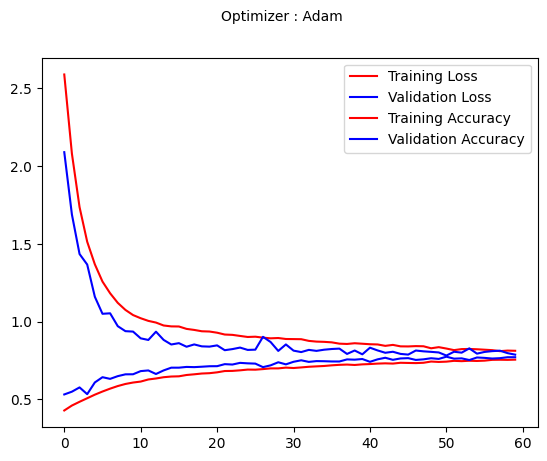

In [83]:
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.plot(emotion_model_info.history["loss"], 'r', label="Training Loss")
plt.plot(emotion_model_info.history["val_loss"], 'b', label="Validation Loss")
plt.legend()


plt.plot(emotion_model_info.history["accuracy"],
         'r', label="Training Accuracy")
plt.plot(emotion_model_info.history["val_accuracy"],
         'b', label="Validation Accuracy")
plt.legend()

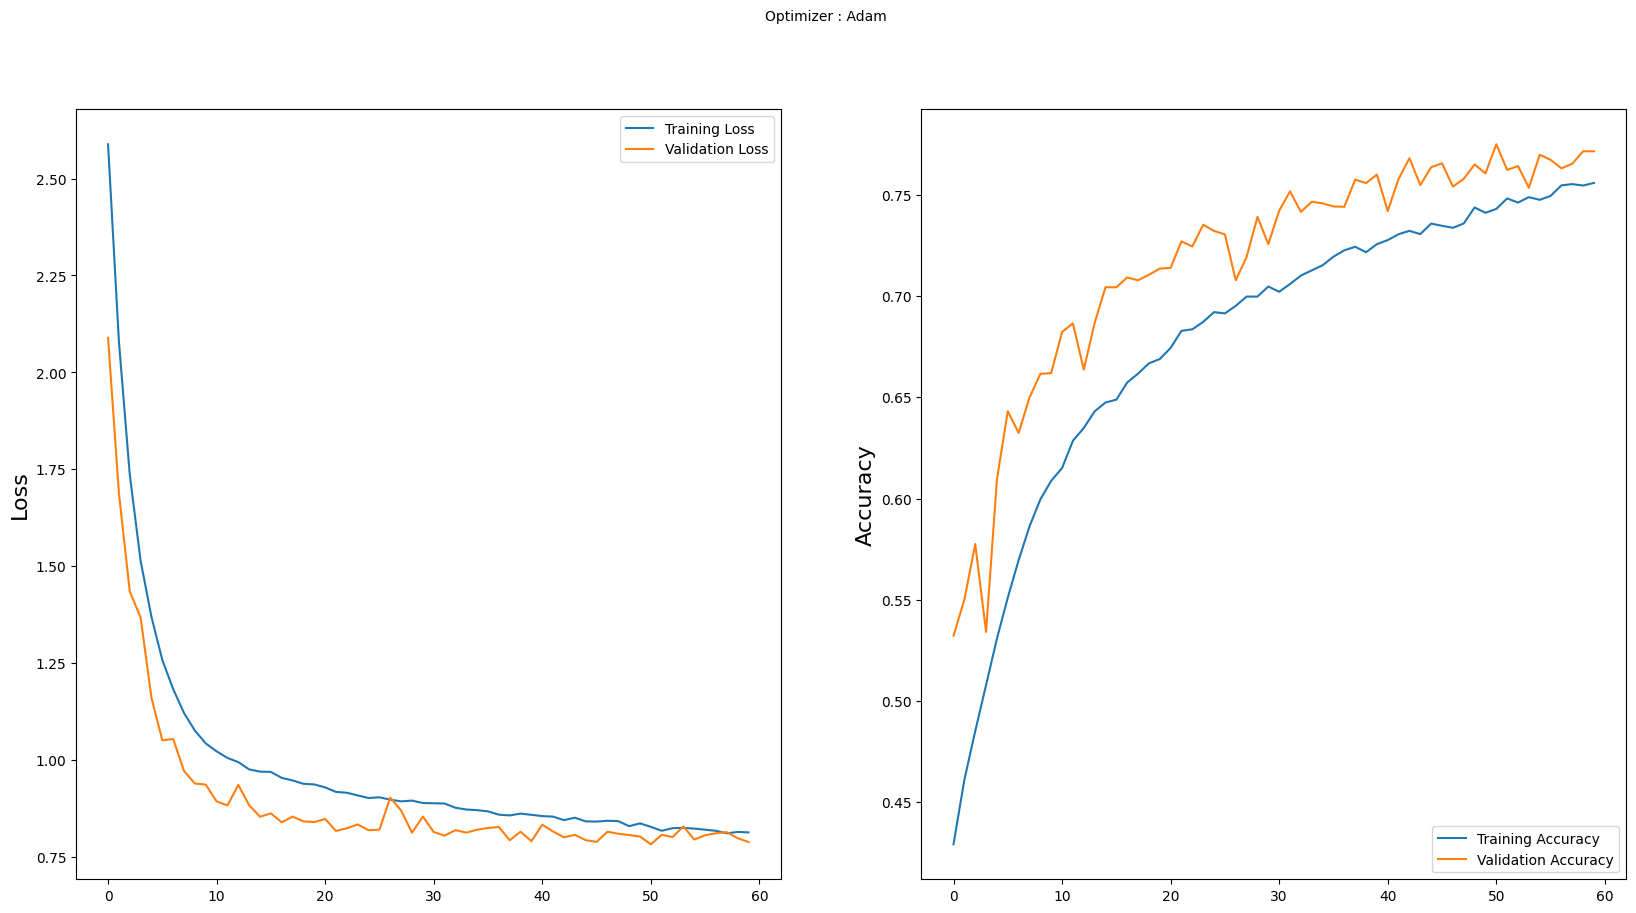

In [84]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(emotion_model_info.history['loss'], label='Training Loss')
plt.plot(emotion_model_info.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(emotion_model_info.history['accuracy'], label='Training Accuracy')
plt.plot(
    emotion_model_info.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [89]:
X_test_batches = []
y_test_batches = []

for i in range(len(validation_generator)):
    X_test, y_test = validation_generator.next()
    X_test_batches.append(X_test)
    y_test_batches.append(y_test)

X_test = np.concatenate(X_test_batches, axis=0)
y_test = np.concatenate(y_test_batches, axis=0)

In [90]:
loss = model.evaluate(X_test, y_test)
print("Test Acc: " + str(loss[1]))

163/163 [==============================] - 4s 26ms/step - loss: 0.7879 - accuracy: 0.7715
Test Acc: 0.7714888453483582


In [92]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

163/163 [==============================] - 3s 19ms/step


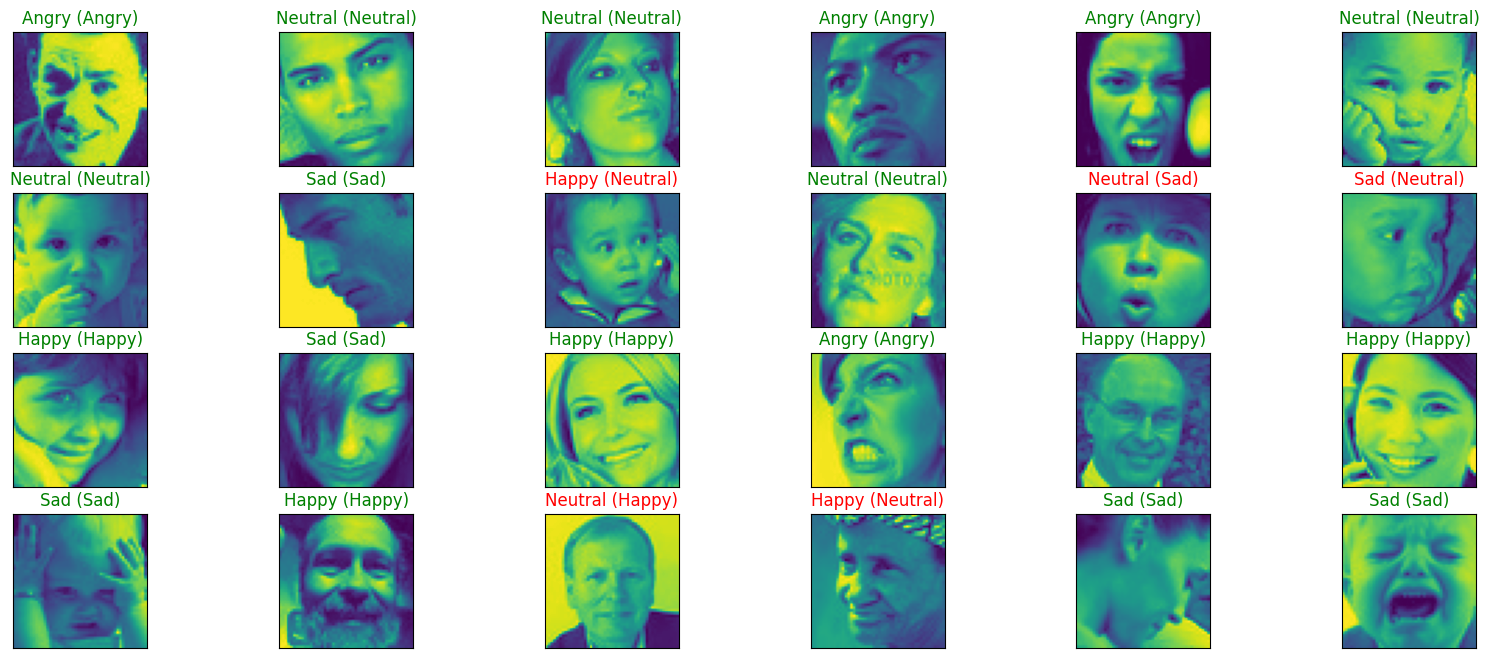

In [95]:
# seeing predicted emotion and actual emotion of a randomly generated particular image of the testing dataset

label_dict = {0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test, axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                 color=("green" if predict_index == true_index else "red"))

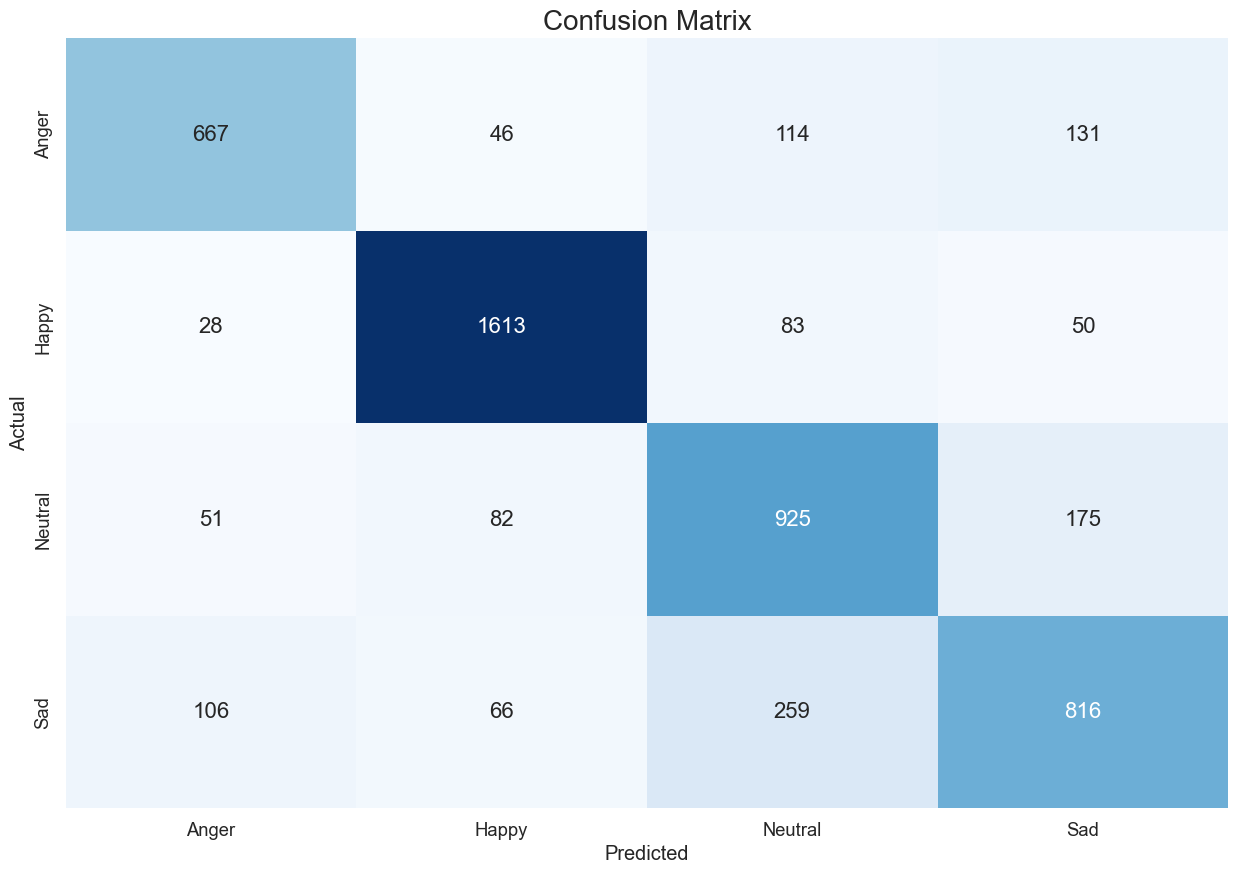

In [101]:
import pandas as pd
import seaborn as sns
CLASS_LABELS = ['Anger', 'Happy', 'Neutral', 'Sad']

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True,
                 annot_kws={"size": 16}, fmt='g')

In [124]:
# Save model weights
model.save_weights("custom_model_weights.h5")